In [34]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [35]:
#load data from csv file to panda dataframe
data = pd.read_csv('/content/50_Startups.csv')
data.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [36]:
#checking for column data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [37]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


In [39]:
#drop duplicate rows (if any)
data.drop_duplicates(inplace=True)

In [40]:
#check for null values
data.isnull().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

<Axes: xlabel='variable', ylabel='value'>

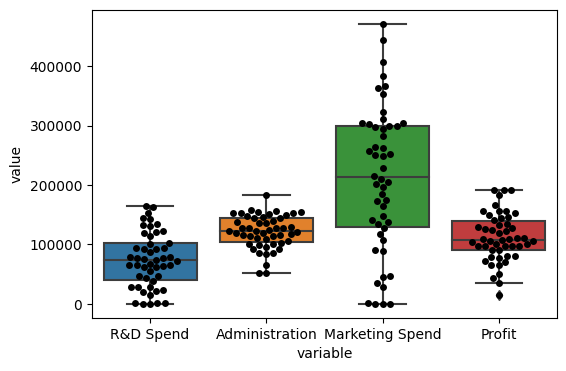

In [41]:
#there are no null values
#we proceed for removing outliers in the dataset
numerical_cols = [col for col in data if data[col].dtype=='float64']
data_melted=pd.melt(data, value_vars=numerical_cols)
plt.figure(figsize=(6,4))
sns.boxplot(x='variable',y='value',data=data_melted)
sns.swarmplot(x='variable',y='value',data=data_melted, color='black')

In [42]:
#we can see some outliers in the profit column
#we use the IQR method for removing them (since data is not gaussian)
for col in numerical_cols:
    quartile1 = data[col].quantile(0.25)
    quartile3 = data[col].quantile(0.75)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    data = data[(data[col]<upper_limit) & (data[col]>lower_limit)]

In [43]:
data.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,49.000000,49.000000,49.000000,49.000000
mean,75226.138367,121433.636327,214409.833265,113998.991020
std,45115.141560,28301.008988,121168.170072,38171.246893
min,0.000000,51283.140000,0.000000,35673.410000
25%,44069.950000,103057.490000,134050.070000,90708.190000
50%,73994.560000,122782.750000,214634.810000,108552.040000
75%,101913.080000,145077.580000,299737.290000,141585.520000
max,165349.200000,182645.560000,471784.100000,192261.830000


In [ ]:
#we can see one outlier has been dropped

In [45]:
#collect all categorical columns for encoding
cat_cols = [col for col in data if data[col].dtype=='object']

In [46]:
#check for trailing whitespaces or capitalization errors in categorical cols
for col in cat_cols:
    print(col)
    print(data[col].unique())

State
['New York' 'California' 'Florida']


In [47]:
#since there are only 3 categories as intended, we proceed with One Hot Encoding.
#we are using OHE, since there is no ordered relation between the categories (data is nominal).
from sklearn.preprocessing import OneHotEncoder
oh_encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
encoded_cols = pd.DataFrame(oh_encoder.fit_transform(data[cat_cols]))
encoded_cols.index = data.index
encoded_cols.columns = oh_encoder.get_feature_names_out(cat_cols)
dropped_data = data.drop(cat_cols,axis=1)
encoded_data = pd.concat([dropped_data,encoded_cols], axis=1)
encoded_data.head()

,R&D Spend,Administration,Marketing Spend,Profit,State_California,State_Florida,State_New York
0,165349.20,136897.80,471784.10,192261.83,0.0,0.0,1.0
1,162597.70,151377.59,443898.53,191792.06,1.0,0.0,0.0
2,153441.51,101145.55,407934.54,191050.39,0.0,1.0,0.0
3,144372.41,118671.85,383199.62,182901.99,0.0,0.0,1.0
4,142107.34,91391.77,366168.42,166187.94,0.0,1.0,0.0


In [54]:
#different scaling or normalization methods are used depending on the model
#since we do not know the learning model to be used, we are not performing it here
#but this should be done before feeding to model to improve accuracy

#save processed data to csv file
encoded_data.to_csv('/content/preprocessed_data.csv', index=False)

In [53]:
#split training and testing data
from sklearn.model_selection import train_test_split
y = encoded_data['Profit']
X = encoded_data.drop('Profit',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)